In [1]:
import numpy as np
import os
from os import listdir as ld
from os.path import join as pj
from PIL import Image
import pandas as pd
from sklearn.mixture import GaussianMixture as GMM
import matplotlib.pyplot as plt
%matplotlib inline

from IO.loader import parse_annotations, file_id
from IO.build_ds import load_anno, create_annotation, build_classification_ds
from IO.create_bbox2size_ds import divide_target_and_body, get_new_anno_with_size
from utils.crop import *

### Create image2size dataset

In [2]:
data_root = pj(os.getcwd(), "data")
img_folder = "refined_images"
anno_folders = ["annotations_0", "annotations_2", "annotations_3", "annotations_4", "annotations_20200806"]

unused_labels = [']', 'Coleoptera', 'Hemiptera', 
                 'Hymenoptera', 'Megaloptera', 'Unknown', 
                 'unknown', 'medium insect', 'small insect', 
                 'snail', 'spider']

In [3]:
images, anno = load_anno(data_root, img_folder, anno_folders, return_body=True)
new_anno = create_annotation(images, anno, unused_labels, False, False)
new_anno_div_body = divide_target_and_body(new_anno)
new_anno_with_size = get_new_anno_with_size(new_anno_div_body)

imgs, lbls, sizes = build_classification_ds(new_anno_with_size, images, crop=crop_adjusted_std, return_sizes=True)

loading path ...
loading images ...
loading annos ...


100%|██████████| 138/138 [12:40<00:00,  5.51s/it]


{'Diptera': 0, 'Ephemeridae': 1, 'Ephemeroptera': 2, 'Lepidoptera': 3, 'Plecoptera': 4, 'Trichoptera': 5}


In [4]:
idx, count = np.unique(lbls, return_counts=True)
count

array([ 400,  105,  194, 1070,  399,  308])

### visualize distribution (Ground Truth)

In [5]:
figure_root = pj(os.getcwd(), "result/size_estimation/size_distributions")
data_output_root = pj(os.getcwd(), "figure/det2cls/master_paper/refinedet_plus_other_resnet_size")
if os.path.exists(figure_root) is False:
    os.makedirs(figure_root)
if os.path.exists(data_output_root) is False:
    os.makedirs(data_output_root)

In [9]:
cls_and_size_df_gt = pd.DataFrame({"lbl": np.array(lbls), "size": np.array(sizes)})
cls_and_size_df_gt.to_csv(pj(data_output_root, "cls_and_size_df_gt.csv"))

In [10]:
lbl_to_name = {
    0: 'Diptera', 
    1: 'Ephemeridae', 
    2: 'Ephemeroptera', 
    3: 'Lepidoptera', 
    4: 'Plecoptera', 
    5: 'Trichoptera', 
}

In [11]:
def get_insect_size_dic(Y, sizes, lbl_to_name):
    """
        get dictionary of label to size
        Args:
            - Y: np.array(dtype=int), shape==[insect_num]
            - sizes: np.array(dtype=float), shape==[insect_num]
            - lbl_to_name: dict, {label: label_name}
    """
    insect_size_dic = {}
    for i in range(len(lbl_to_name)):
        insect_filter = Y == i
        filtered_X_size = sizes[insect_filter]
        filtered_X_size = np.sort(filtered_X_size)
        insect_size_dic.update({lbl_to_name[i]: filtered_X_size})
    return insect_size_dic

def gaussian(mu, sigma):
    """
        return gaussian distribution
        Args:
            - mu: np.array(dtype=float), shape=[K]
            - sigma: np.array(dtype=float), shape=[K]
    """
    def f(x):
        return np.exp(-0.5 * (x - mu) ** 2 / sigma) / np.sqrt(2 * np.pi * sigma)
    return f

def laplace(mu, sigma):
    """
        return laplace distribution
        Args:
            - mu: np.array(dtype=float), shape=[K]
            - sigma: np.array(dtype=float), shape=[K]
    """
    b = np.sqrt(sigma / 2)
    def f(x):
        return 1 / (2 * b) * np.exp(-1 * np.abs(x - mu) / b)
    return f

def calc_mu_sigma(insect_size_dic):
    """
        calculate mu, sigma for each insect size distribution
        Args:
            - insect_size_dic: dict, {label_name: size_array}
    """
    gmm = GMM(n_components=1, covariance_type="spherical")
    mu = []
    sigma = []
    for key, value in insect_size_dic.items():
        x = np.log2(insect_size_dic[key])
        gmm.fit(x.reshape(-1, 1))
        mu.append(gmm.means_.reshape([-1])[0])
        sigma.append(np.sqrt(gmm.covariances_)[0])
    return np.array(mu), np.array(sigma)

def plot_hist_and_distribution(x, seq, mu, sigma, label_name, x_uniform=None, mu_uniform=None, sigma_uniform=None):
    """
        plot histgram and gaussian distribution
        Args:
            - x: np.array(dtype=float)
            - seq: np.array(dtype=float)
            - mu: np.array(dtype=float), shape == [class_num]
            - sigma: np.array(dtype=float), shape == [class_num]
            - label_name: str
            - x_uniform: np.array(dtype=float)
            - mu_uniform: np.array(dtype=float), shape == [class_num]
            - sigma_uniform: np.array(dtype=float), shape == [class_num]
    """
    if x_uniform is not None and mu_uniform is not None and sigma_uniform is not None:
        fig, axe = plt.subplots(1, 2, figsize=(10, 5))
        axe[0].hist(x, bins=100, density=True)
        axe[0].plot(seq, gaussian(mu, sigma)(seq), linewidth=2, color="red")
        axe[0].set_title(label_name + " (default)")
        axe[1].hist(x_uniform, bins=100, density=True)
        axe[1].plot(seq, gaussian(mu_uniform, sigma_uniform)(seq), linewidth=2, color="red")
        axe[1].set_title(label_name + " (random resize)")
    else:
        plt.hist(x, bins=100, density=True)
        plt.plot(seq, gaussian(mu, sigma)(seq), linewidth=2, color="red")
        plt.title(label_name)

In [12]:
insect_size_dic = get_insect_size_dic(lbls, sizes, lbl_to_name)

In [13]:
mu, sigma = calc_mu_sigma(insect_size_dic)
gauss_df = pd.DataFrame({"mu": mu, "sigma": sigma})
gauss_df.index = ["Diptera", "Ephemeridae", "Ephemeroptera", "Lepidoptera", "Plecoptera", "Trichoptera"]
gauss_df

,mu,sigma
Diptera,4.388058,0.767773
Ephemeridae,6.390962,0.294352
Ephemeroptera,5.119300,0.675633
Lepidoptera,5.833527,0.579016
Plecoptera,5.460814,0.420820
Trichoptera,5.585883,0.463656


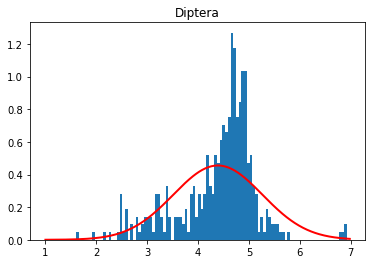

In [14]:
x = np.log2(insect_size_dic["Diptera"])
seq = np.arange(1.0, 7.0, 0.02)
plot_hist_and_distribution(x, seq, mu[0], sigma[0], "Diptera")

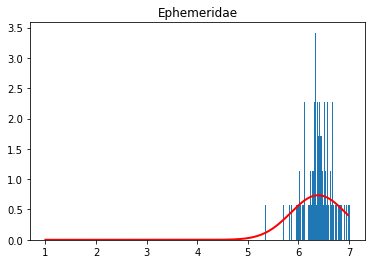

In [15]:
x = np.log2(insect_size_dic["Ephemeridae"])
seq = np.arange(1.0, 7.0, 0.02)
plot_hist_and_distribution(x, seq, mu[1], sigma[1], "Ephemeridae")

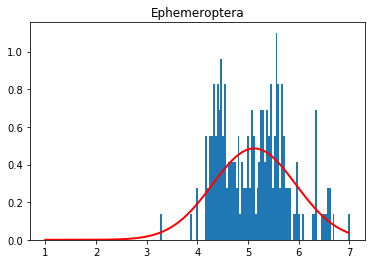

In [16]:
x = np.log2(insect_size_dic["Ephemeroptera"])
seq = np.arange(1.0, 7.0, 0.02)
plot_hist_and_distribution(x, seq, mu[2], sigma[2], "Ephemeroptera")

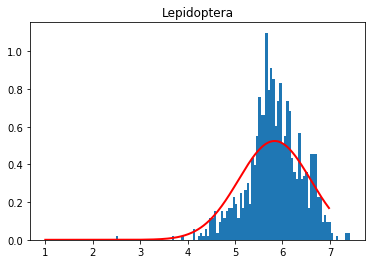

In [17]:
x = np.log2(insect_size_dic["Lepidoptera"])
seq = np.arange(1.0, 7.0, 0.02)
plot_hist_and_distribution(x, seq, mu[3], sigma[3], "Lepidoptera")

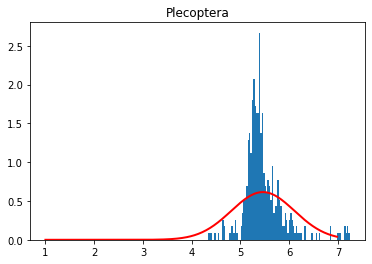

In [18]:
x = np.log2(insect_size_dic["Plecoptera"])
seq = np.arange(1.0, 7.0, 0.02)
plot_hist_and_distribution(x, seq, mu[4], sigma[4], "Plecoptera")

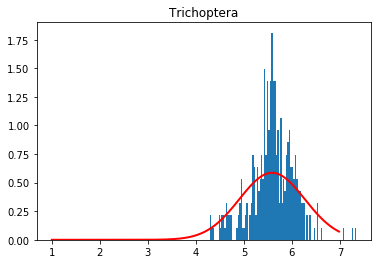

In [19]:
x = np.log2(insect_size_dic["Trichoptera"])
seq = np.arange(1.0, 7.0, 0.02)
plot_hist_and_distribution(x, seq, mu[5], sigma[5], "Trichoptera")

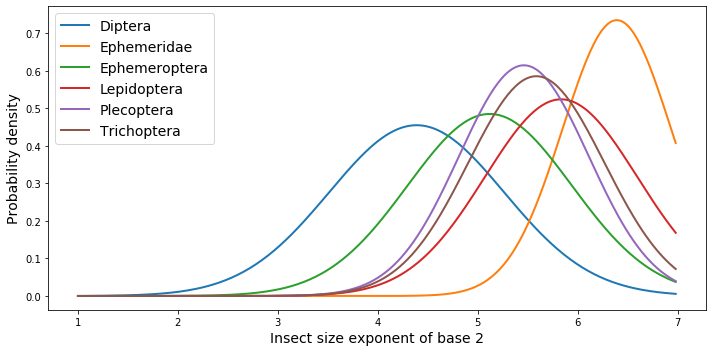

In [20]:
plt.figure(figsize=(10,5))
plt.plot(seq, gaussian(mu[0], sigma[0])(seq), linewidth=2, label="Diptera")
plt.plot(seq, gaussian(mu[1], sigma[1])(seq), linewidth=2, label="Ephemeridae")
plt.plot(seq, gaussian(mu[2], sigma[2])(seq), linewidth=2, label="Ephemeroptera")
plt.plot(seq, gaussian(mu[3], sigma[3])(seq), linewidth=2, label="Lepidoptera")
plt.plot(seq, gaussian(mu[4], sigma[4])(seq), linewidth=2, label="Plecoptera")
plt.plot(seq, gaussian(mu[5], sigma[5])(seq), linewidth=2, label="Trichoptera")
plt.xlabel("Insect size exponent of base 2", fontsize=14)
plt.ylabel("Probability density", fontsize=14)
plt.tight_layout()
plt.legend(fontsize=14)
plt.savefig(pj(figure_root, "size_distribution.png"))